In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, chi2_contingency

from diurnal_misinformation.config import ItalyConfig
from diurnal_misinformation.utils import groupby_with_total, format_h_min
from diurnal_misinformation.path_utils import save_to_latex, save_plot
from diurnal_misinformation.enums import Columns, FactTypes, ContentType, Clusters
from diurnal_misinformation.data_processor import DataProcessor, user_mapping, disinformative_mapping
from diurnal_misinformation.fourier_utils import FourierRoutine

In [2]:
np.random.seed(0)
config = ItalyConfig()
processor = DataProcessor(config)

Tweets were collected based on keywords and hashtags related to Covid (as described in Gallotti2020). In the following, we only look at Tweets that were classified with a FactType, meaning that they contain a URL in one of the domains in the database by Gallotti2020.
We assume that circadian rhythms have a similar effect on tweets with and without URLS.

# Time-independent

In [3]:
pd.crosstab(
    processor.data.index.get_level_values(Columns.VERIFIED.value), 
    processor.cluster_mapping(processor.data, 'all'), 
    rownames=[Columns.VERIFIED.value],
    colnames=[Columns.CLUSTER.value],
    values=processor.data[Columns.POSTS.value].to_numpy(), margins=True, dropna=False, aggfunc=sum, margins_name='total'
)[Clusters.total_order()]

cluster,infrequent type,morning type,intermediate type,evening type,total
verified,,,,,
False,7795201,2733078,5015449,2308654,17852382
True,63008,82809,184206,29821,359844
total,7858209,2815887,5199655,2338475,18212226


In [4]:
pd.crosstab(
    processor.data.index.get_level_values(Columns.VERIFIED.value), 
    processor.data.index.get_level_values(Columns.FACTTYPE.value),  
    values=processor.data[Columns.POSTS.value].to_numpy(), 
    rownames=[Columns.VERIFIED.value],
    colnames=[Columns.FACTTYPE.value],
    margins=True, dropna=False, aggfunc=sum, margins_name='total'
)[FactTypes.order('name') + ['total']]

FactType,Science,Mainstream Media,Satire,Clickbait,Other,Political,Fake or hoax,Conspiracy & junk science,total
verified,,,,,,,,,
False,18597,719388,4289,12189,16890445,98202,43716,65556,17852382
True,234,38273,12,8,320542,498,172,105,359844
total,18831,757661,4301,12197,17210987,98700,43888,65661,18212226


## FactType counts and ratios

Sum of posts per fact type and cluster: $\sum_{t \in T, \ i \in c}|P_{(t,i,f)|}$

In [5]:
ft_posts_per_cluster = pd.crosstab(
    processor.data.index.get_level_values(Columns.FACTTYPE.value), 
    processor.cluster_mapping(processor.data, 'all'), 
    values=processor.data[Columns.POSTS.value].to_numpy(), 
    rownames=[Columns.FACTTYPE.value],
    colnames=[Columns.CLUSTER.value],
    margins=True, dropna=False, aggfunc=sum,
    margins_name='total'
)
ft_posts_per_cluster.loc[ContentType.DISINFORMATIVE.value] = ft_posts_per_cluster.loc[FactTypes.disinformative_order(attribute='name')].sum(axis=0)
ft_posts_per_cluster.loc[ContentType.KNOWN.value] = ft_posts_per_cluster.loc['total'] - ft_posts_per_cluster.loc['Other']
ft_posts_per_cluster.loc[ContentType.CLEAR.value] = ft_posts_per_cluster.loc[ContentType.KNOWN.value] - ft_posts_per_cluster.loc[ContentType.DISINFORMATIVE.value]

In [6]:
ft_posts_per_cluster.loc[FactTypes.order() + [ContentType.DISINFORMATIVE.value, 'total'], Clusters.total_order()]

cluster,infrequent type,morning type,intermediate type,evening type,total
FactType,,,,,
Science,7251,3407,4923,3250,18831
Mainstream Media,251854,136038,262554,107215,757661
Satire,2430,457,961,453,4301
Clickbait,8769,1063,1369,996,12197
Other,7536310,2632684,4870705,2171288,17210987
Political,32948,15982,19658,30112,98700
Fake or hoax,9876,8429,13287,12296,43888
Conspiracy & junk science,8771,17827,26198,12865,65661
potentially disinformative,51595,42238,59143,55273,208249


Cluster ratio as sum of content type over sum of content: $\frac{\sum_{t \in T, \ i \in c}|P_{(t,i,f)|} }{\sum_{t \in T, \ i \in c, f \in F}|P_{(t,i,f)|}}$

In [7]:
ft_posts_per_cluster.div(ft_posts_per_cluster.loc['total'], axis=1).loc[FactTypes.order() + [ContentType.DISINFORMATIVE.value], Clusters.total_order()]

cluster,infrequent type,morning type,intermediate type,evening type,total
FactType,,,,,
Science,0.000923,0.001210,0.000947,0.001390,0.001034
Mainstream Media,0.032050,0.048311,0.050495,0.045848,0.041602
Satire,0.000309,0.000162,0.000185,0.000194,0.000236
Clickbait,0.001116,0.000378,0.000263,0.000426,0.000670
Other,0.959037,0.934940,0.936736,0.928506,0.945024
Political,0.004193,0.005676,0.003781,0.012877,0.005419
Fake or hoax,0.001257,0.002993,0.002555,0.005258,0.002410
Conspiracy & junk science,0.001116,0.006331,0.005038,0.005501,0.003605
potentially disinformative,0.006566,0.015000,0.011374,0.023636,0.011435


### Known fact types only
$\frac{\sum_{t \in T, \ i \in c}|P_{(t,i,f)|} }{\sum_{t \in T, \ i \in c, f \in F^K}|P_{(t,i,f)|}}$

In [8]:
ft_posts_per_cluster.div(ft_posts_per_cluster.loc[ContentType.KNOWN.value], axis=1).loc[FactTypes.known_order() + [ContentType.DISINFORMATIVE.value], Clusters.total_order()]

cluster,infrequent type,morning type,intermediate type,evening type,total
FactType,,,,,
Science,0.022526,0.018597,0.014966,0.019439,0.018808
Mainstream Media,0.782401,0.742553,0.798158,0.641288,0.756723
Satire,0.007549,0.002495,0.002921,0.002710,0.004296
Clickbait,0.027241,0.005802,0.004162,0.005957,0.012182
Political,0.102355,0.087237,0.059760,0.180110,0.098578
Fake or hoax,0.030680,0.046009,0.040392,0.073546,0.043834
Conspiracy & junk science,0.027248,0.097307,0.079641,0.076950,0.065580
potentially disinformative,0.160283,0.230553,0.179793,0.330606,0.207991


#### $\chi^2-Test$ 
<p id="Chi2Disinf">Mentioned in Evening types spread most potentially disinformative content, infrequent posters the least</p>

Evening types post significantly more potentially machinated content than the other clusters, particularly fake or hoax content and politically biased news. Infrequent type users post disproportionately much Clickbait.

In [9]:
chi2mp=pd.DataFrame(index=[ContentType.DISINFORMATIVE.value, Columns.FACTTYPE.value], columns=['Chi2', 'P-value'])
chi2mp.loc[ContentType.DISINFORMATIVE.value] = chi2_contingency(ft_posts_per_cluster.loc[[ContentType.DISINFORMATIVE.value, ContentType.CLEAR.value], Clusters.order()])[:2]
chi2mp.loc[Columns.FACTTYPE.value] = chi2_contingency(ft_posts_per_cluster.loc[FactTypes.known_order(), Clusters.order()])[:2]

In [10]:
chi2mp_style = chi2mp.style.format('{:.2f}').format('{:.1e}', subset='P-value')
save_to_latex(config, chi2mp_style, 'chi_square_content_types', caption=r"Chi Square test of difference in distributions in between content types.", is_multi_index=True)
chi2mp_style

,Chi2,P-value
potentially disinformative,21860.01,0.0e+00
FactType,47245.84,0.0e+00


 The p-values are smaller than 0.05 and therefore tells us that the clusters show statistically significant differences in their distributions between content types.
Our null hypothesis (user cluster and spreading of harmful content/content types are independent) can be rejected.

### Aggregated per user and averaged over cluster
cluster ratio an average of user ratios: $r(f,c) = \frac{1}{|c|} \sum_{i \in c} \frac{\sum_{t \in T}|P_{(t,i,f)|} }{\sum_{t \in T, g \in F^K}|P_{(t,i,g)|}}$

In [11]:
ratio_of_known_per_user_ft = processor.posts_per_user_ft.div(processor.posts_per_user_ft[ContentType.KNOWN.value], axis=0).dropna()[FactTypes.known_order() + [ContentType.DISINFORMATIVE.value]]
ratio_of_known_per_user_cluster_ft = groupby_with_total(ratio_of_known_per_user_ft, [user_mapping(ratio_of_known_per_user_ft, processor.cluster_cols['all'])], 'mean').loc[Clusters.total_order(), FactTypes.known_order() + [ContentType.DISINFORMATIVE.value]]
ratio_of_known_per_user_cluster_ft

FactType,Science,Mainstream Media,Satire,Clickbait,Political,Fake or hoax,Conspiracy & junk science,potentially disinformative
userhash,,,,,,,,
infrequent type,0.022649,0.760615,0.008491,0.041109,0.121679,0.026584,0.018873,0.167137
morning type,0.020301,0.763024,0.005028,0.008257,0.080250,0.045403,0.077738,0.203391
intermediate type,0.019924,0.785881,0.006613,0.005750,0.069360,0.040522,0.071950,0.181832
evening type,0.021746,0.668707,0.003681,0.008756,0.174236,0.061355,0.061519,0.297110
total,0.022481,0.759755,0.008251,0.038464,0.119919,0.028194,0.022936,0.171049


## User statistics per fact type

In [12]:
def sum_mean_median_agg(x, all_posts_per_user):
    group_posts = all_posts_per_user.loc[x.index.get_level_values(Columns.USERHASH.value)].repeat(x.values)
    return pd.Series([x.sum(), group_posts.mean(), group_posts.median()], index=['total posts', 'mean posts per author', 'median posts per author'], name='stats')

In [13]:
facttype_stats = (processor
    .posts_per_user_ft[FactTypes.known_order('name') + [ContentType.DISINFORMATIVE.value]]
    .apply(lambda x: sum_mean_median_agg(x, processor.posts_per_user_ft['total']))
)

<p id="SupplTab2">Supplementary Table 1</p>

In [14]:
facttype_stats_style = (
    pd.concat([facttype_stats, ratio_of_known_per_user_cluster_ft]).T.iloc[:,:-1]
    .rename(columns={c:c.split()[0] for c in Clusters.order()})
    .style
    .format('{:,.3f}', na_rep="-")
    .format('{:,.0f}', subset=facttype_stats.index)
)
save_to_latex(config, facttype_stats_style, 'suppl_tab_1_content_type', caption=r"Ratios of posts by content type and cluster. Ratios are averaged per user.")
facttype_stats_style

,total posts,mean posts per author,median posts per author,infrequent,morning,intermediate,evening
FactType,,,,,,,
Science,"18,831","2,261",484,0.023,0.020,0.020,0.022
Mainstream Media,"757,661","2,682",672,0.761,0.763,0.786,0.669
Satire,"4,301",734,170,0.008,0.005,0.007,0.004
Clickbait,"12,197",735,39,0.041,0.008,0.006,0.009
Political,"98,700","2,755",721,0.122,0.080,0.069,0.174
Fake or hoax,"43,888","2,601","1,143",0.027,0.045,0.041,0.061
Conspiracy & junk science,"65,661","4,275","1,679",0.019,0.078,0.072,0.062
potentially disinformative,"208,249","3,202","1,110",0.167,0.203,0.182,0.297


## Verified/Unverified and FactType counts and ratios

In [15]:
posts_per_verified_ft = pd.crosstab(
    processor.data.index.get_level_values(Columns.FACTTYPE.value),  
    processor.data.index.get_level_values(Columns.VERIFIED.value), 
    rownames=[Columns.FACTTYPE.value],
    colnames=[Columns.VERIFIED.value],
    values=processor.data[Columns.POSTS.value].to_numpy(), margins=True, dropna=False, aggfunc=sum, margins_name='total'
)
posts_per_verified_ft.loc[ContentType.DISINFORMATIVE.value] = posts_per_verified_ft.loc[FactTypes.disinformative_order()].sum(axis=0)
posts_per_verified_ft.div(posts_per_verified_ft.loc['total'], axis=1).loc[FactTypes.order() + [ContentType.DISINFORMATIVE.value], :]

verified,False,True,total
FactType,,,
Science,0.001042,0.000650,0.001034
Mainstream Media,0.040296,0.106360,0.041602
Satire,0.000240,0.000033,0.000236
Clickbait,0.000683,0.000022,0.000670
Other,0.946117,0.890780,0.945024
Political,0.005501,0.001384,0.005419
Fake or hoax,0.002449,0.000478,0.002410
Conspiracy & junk science,0.003672,0.000292,0.003605
potentially disinformative,0.011622,0.002154,0.011435


### Known FactTypes only

In [16]:
ratio_of_known_per_tweet_ft_verified = posts_per_verified_ft.div(posts_per_verified_ft.loc[FactTypes.known_order()].sum(axis=0), axis=1)
ratio_of_known_per_tweet_ft_verified.loc[FactTypes.known_order() + [ContentType.DISINFORMATIVE.value], :]

verified,False,True,total
FactType,,,
Science,0.019333,0.005954,0.018808
Mainstream Media,0.747854,0.973818,0.756723
Satire,0.004459,0.000305,0.004296
Clickbait,0.012671,0.000204,0.012182
Political,0.102088,0.012671,0.098578
Fake or hoax,0.045446,0.004376,0.043834
Conspiracy & junk science,0.068150,0.002672,0.065580
potentially disinformative,0.215684,0.019719,0.207991


### aggregated by user and averaged over verified/unverified
There are some users whose verification status changed. Therefore we must repeat the aggregation process.

In [17]:
posts_per_user_ft_verified = (
    processor.data[Columns.POSTS.value]
    .groupby([Columns.VERIFIED.value, Columns.USERHASH.value, Columns.FACTTYPE.value]).sum()
    .unstack(level=Columns.FACTTYPE.value, fill_value=0)
)
posts_per_user_ft_verified[ContentType.DISINFORMATIVE.value] = posts_per_user_ft_verified[FactTypes.disinformative_order()].sum(axis=1)

In [18]:
ratio_of_known_per_user_ft_verified = groupby_with_total(
    posts_per_user_ft_verified.div(posts_per_user_ft_verified[FactTypes.known_order()].sum(axis=1), axis=0).dropna(), 
    [Columns.VERIFIED.value], 'mean')

In [19]:
ratios_by_verified = (pd.concat([ratio_of_known_per_tweet_ft_verified, ratio_of_known_per_user_ft_verified.T], keys=['ratio by tweet', 'ratio by user'], axis=1)
    .rename(columns={True: 'verified', False: 'unverified'})
    .loc[FactTypes.known_order() + [ContentType.DISINFORMATIVE.value], pd.IndexSlice[['ratio by tweet', 'ratio by user'], ['unverified', 'verified']]]
)

<p id="SupplTab16">Supplementary Table 6</p>

In [20]:
ratios_by_verified_style = ratios_by_verified.style.format(lambda v: '< 0.001' if round(v, 3) < .001 else f'{v:.03f}')
save_to_latex(
    config,
    ratios_by_verified_style, 
    'content_type_ratios_by_verified',
    r"Ratios of posts by content type and verification of user.",
    is_multi_index=True)
ratios_by_verified_style

#### $\chi^2$-Test
<p id="SupplNoteB">Mentioned in Supplementary Note B</p>

In [21]:
posts_per_verified_ft.loc[ContentType.CLEAR.value] = posts_per_verified_ft.loc[list(set(FactTypes.known_order()) - set(FactTypes.disinformative_order()))].sum(axis=0)


In [22]:
res_f =  chi2_contingency(posts_per_verified_ft.drop(columns='total').loc[FactTypes.known_order()])
res_h = chi2_contingency(posts_per_verified_ft.drop(columns='total').loc[[ContentType.DISINFORMATIVE.value, ContentType.CLEAR.value]])

In [23]:
f'FactTypes: chi^={res_f[0]:.2f}, p={res_f[1]:.3f}\Disinformative or not: chi^={res_h[0]:.2f}, p={res_h[1]:.3f}'

'FactTypes: chi^=10524.71, p=0.000\\Disinformative or not: chi^=8801.25, p=0.000'

# Correlation of overall posts per user with ratio of potentially disinformative content

In [24]:
posts_per_cluster_userposts_disinf = processor.get_per_cluster_x('all', processor.known_data[Columns.POSTS.value], 'sum', columns=[user_mapping(processor.known_data, processor.posts_per_user, 'posts per user'), disinformative_mapping(processor.known_data)])
disinf_ratio_per_cluster_userposts = posts_per_cluster_userposts_disinf.xs(True, level=ContentType.DISINFORMATIVE.value).div(posts_per_cluster_userposts_disinf.groupby(level=[Columns.CLUSTER.value, 'posts per user']).sum())

<p id="Table2">Table 2 (a)</p>

In [25]:
spearman_df_style = (disinf_ratio_per_cluster_userposts.dropna()
 .groupby(Columns.CLUSTER.value)
 .apply(lambda grp: pd.Series(spearmanr(grp.droplevel(0).index, grp.values), index=['Rho', '\pvalue']))
 .unstack(level=-1)
 .loc[Clusters.total_order()]
 .style
 .format({'Rho': lambda x: f'{x:.3f}', '\pvalue': lambda x: f'{x:.1e}'})
 .map(lambda v: 'font-weight: bold;' if (v <0.05)  else None, subset="\pvalue"))
save_to_latex(config,
    spearman_df_style,
    'corr_total_posts',
    r"Spearman's rank correlation coefficient and corresponding \pvalue{} correlating a user's total number of posts with ratios of potentially disinformative content.",
)
spearman_df_style

,Rho,\pvalue
cluster,,
infrequent type,0.162,1.2e-02
morning type,0.179,5.0e-09
intermediate type,0.125,2.8e-06
evening type,0.134,1.4e-05
total,0.200,2.3e-22


# Correlation of cluster activity with ratio of potentially disinformative content by time of day

In [26]:
fourier_routine = FourierRoutine(config, processor)
activity_recomposition = fourier_routine.activity_by_user('all')
disinf_ratio_recomposition = fourier_routine.disinf_ratio_by_user('all')

In [27]:
ratio_of_known_per_cluster_ft_t_by_user = processor.get_per_cluster_x(
    'all', processor.ratio_of_known_per_user_ft_t.unstack(level=Columns.FACTTYPE.value, fill_value=0), 'mean', columns=[Columns.MIN_BINS15.value]
)

In [28]:
spearman_df_facttype = pd.DataFrame(
    index=pd.MultiIndex.from_product((['coarse', 'smoothed'], Clusters.total_order())),
    columns=pd.MultiIndex.from_product(([ContentType.DISINFORMATIVE.value] + FactTypes.disinformative_order('name'),  ['Rho', 'P-Value'])))

for c in Clusters.total_order():
    spearman_df_facttype.loc[('coarse', c), ContentType.DISINFORMATIVE.value] = tuple(spearmanr(activity_recomposition.signal.loc[c], disinf_ratio_recomposition.signal.loc[c]))
    spearman_df_facttype.loc[('smoothed', c), ContentType.DISINFORMATIVE.value] = tuple(spearmanr(activity_recomposition.recomposed_signal.loc[c], disinf_ratio_recomposition.recomposed_signal.loc[c]))
    for f in FactTypes.disinformative_order():
        spearman_df_facttype.loc[('coarse', c), f] = tuple(spearmanr(activity_recomposition.signal.loc[c], ratio_of_known_per_cluster_ft_t_by_user.loc[c,f]))
        spearman_df_facttype.loc[('smoothed', c), f] = tuple(spearmanr(activity_recomposition.recomposed_signal.loc[c], ratio_of_known_per_cluster_ft_t_by_user.loc[c,f]))

<p id="Tab2b">Table 2(b)</p>

In [29]:
spearman_df_facttype_style = (
    spearman_df_facttype[[ContentType.DISINFORMATIVE.value] + FactTypes.disinformative_order('name')]
    .style
    .format(
        {(c,r):f for r,f in zip(['Rho', 'P-Value'], [lambda x: f'{x:.3f}', lambda x: f'{x:.1e}'])
         for c in spearman_df_facttype.columns.unique(level=0)})
    .map(lambda v: 'font-weight: bold;' if (v <0.05)  else None, subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]])
)
save_to_latex(config, 
    spearman_df_facttype_style,
    'spearman_facttype_activity',
    r"Spearman correlation and corresponding p-value comparing a cluster's activity level throughout the day with the ratios of politically biased information, fake or hoax news, and conspiracy or junk science.",
    is_multi_index=True
)
spearman_df_facttype_style

# Variance of potentially disinformative content ratios

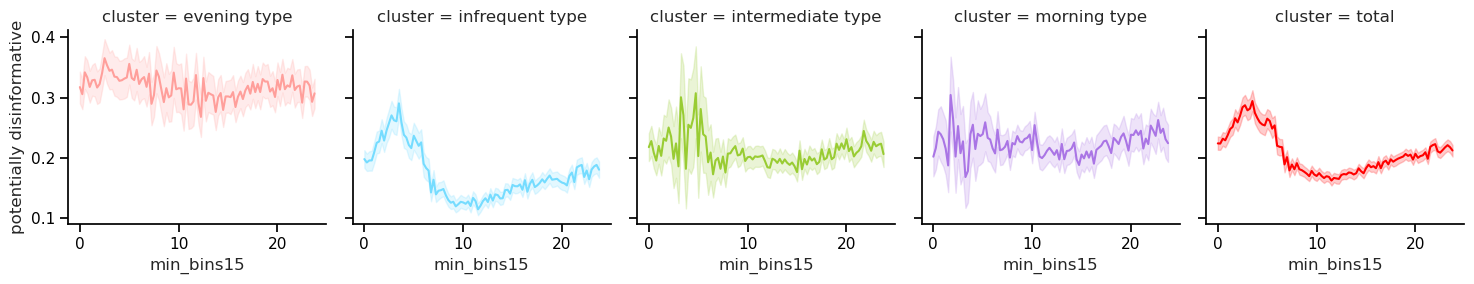

In [30]:
g = sns.FacetGrid(
    data=processor.get_per_cluster_x('all', processor.user_disinf_ratio_t, 'mean', columns=[Columns.MIN_BINS15.value, Columns.USERHASH.value]).reset_index(name=ContentType.DISINFORMATIVE.value), 
    hue=Columns.CLUSTER.value, palette=Clusters.palette(), col=Columns.CLUSTER.value)
g.map_dataframe(sns.lineplot, x=Columns.MIN_BINS15.value, y=ContentType.DISINFORMATIVE.value)

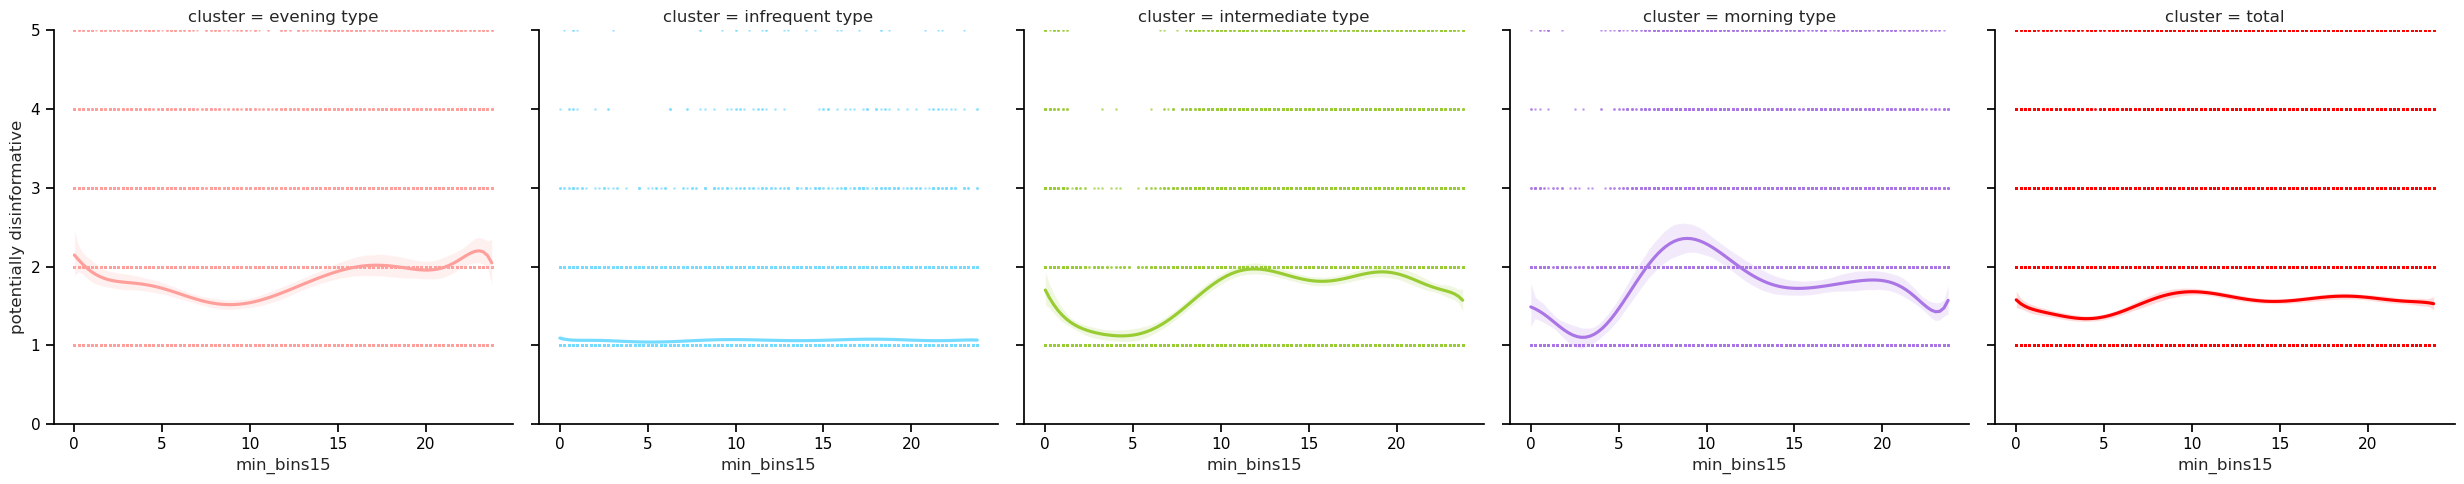

In [31]:
g = sns.lmplot(
    data=processor.get_per_cluster_x('all', processor.disinf_posts_per_user_t, 'sum', columns=[Columns.MIN_BINS15.value, Columns.USERHASH.value]).reset_index(name=ContentType.DISINFORMATIVE.value), 
    x=Columns.MIN_BINS15.value, y=ContentType.DISINFORMATIVE.value, 
    hue=Columns.CLUSTER.value, palette=Clusters.palette(), col=Columns.CLUSTER.value,
    order=10, scatter_kws={'alpha': .5, 's': 1})
g.set(ylim=(0,5))

In [32]:
posts_per_cluster_disinf_t = processor.get_per_cluster_x('all', processor.known_data[Columns.POSTS.value], 'sum', columns=[Columns.MIN_BINS15.value, disinformative_mapping(processor.known_data)]).unstack(level=ContentType.DISINFORMATIVE.value)
posts_per_cluster_disinf_t[ContentType.KNOWN.value] = posts_per_cluster_disinf_t.sum(axis=1)
posts_per_cluster_disinf_t.rename(columns={False: ContentType.CLEAR.value, True: ContentType.DISINFORMATIVE.value}, inplace=True)

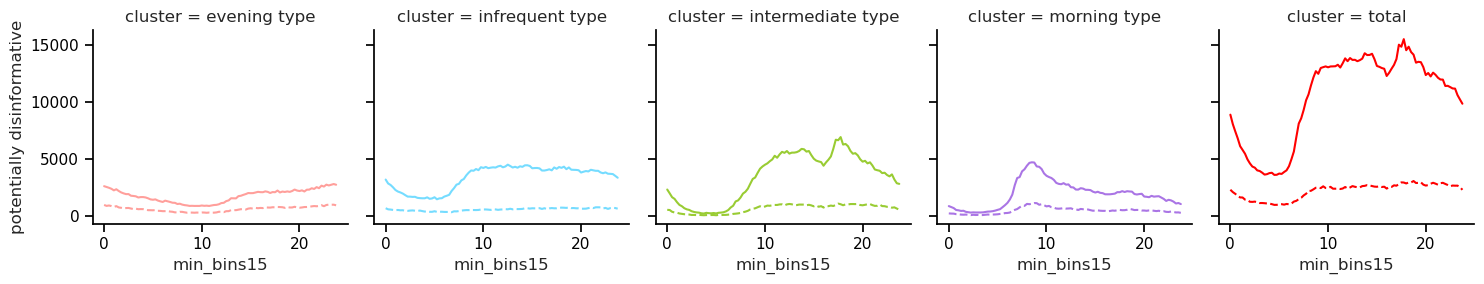

In [33]:
g = sns.FacetGrid(
    data=posts_per_cluster_disinf_t.reset_index(), 
    hue=Columns.CLUSTER.value, palette=Clusters.palette(), col=Columns.CLUSTER.value)
g.map_dataframe(sns.lineplot, x=Columns.MIN_BINS15.value, y=ContentType.KNOWN.value)
g.map_dataframe(sns.lineplot, x=Columns.MIN_BINS15.value, y=ContentType.DISINFORMATIVE.value, linestyle='dashed')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


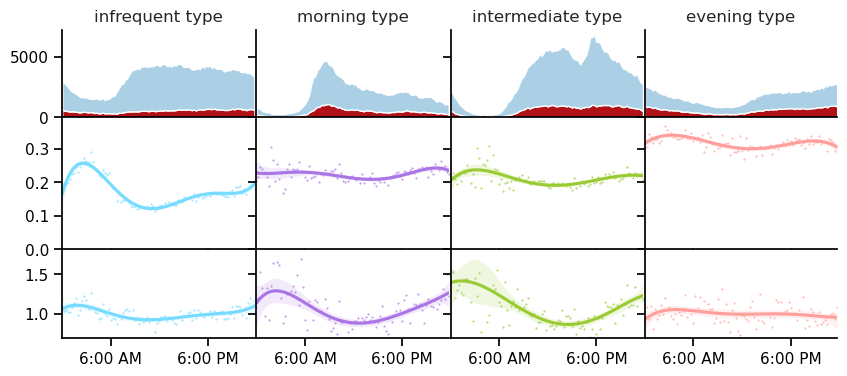

In [34]:
import matplotlib.pyplot as plt
ticks = [6, 18]

fig, axes = plt.subplots(3, 4, gridspec_kw={'height_ratios': [1, 1.5, 1]}, sharex=True, sharey='row', figsize=(10,4))
disinf_activity_recomposition = fourier_routine.disinf_activity_by_user('all')

for i, (c, color) in enumerate(zip(Clusters.order(), Clusters.order('color'))):
    axes[0,i].set_title(c)
    
    # stack plot of potentially disinformative and likely not disinformative values
    axes[0,i].stackplot(
        posts_per_cluster_disinf_t.index.levels[1], posts_per_cluster_disinf_t.loc[c, ContentType.DISINFORMATIVE.value], posts_per_cluster_disinf_t.loc[c, ContentType.CLEAR.value],
        colors=[FactTypes.FAKE.value.color, FactTypes.MSM.value.color]
    )
    # regression of time of day and disinformative content ratio order 5
    sns.regplot(
        x=disinf_ratio_recomposition.signal.columns, y=disinf_ratio_recomposition.signal.loc[c], 
        order=5, ax=axes[1,i], marker = ".", ci=95, color=color, scatter_kws={'s':1})
    
    # regression of time of day and the relationship between disinformative and overall activity order 5
    tmp = disinf_activity_recomposition.signal.loc[c] / activity_recomposition.signal.loc[c]
    sns.regplot(
        x=tmp.index, y=tmp.values, color=color, ax=axes[2,i], order=5, marker = ".", ci=95, scatter_kws={'s':1})

    
for ax in axes.flat:
    ax.set_ylabel("")
    ax.set_xlabel("")
axes[1,0].set_xlim(0,23.75)
axes[1,0].set_ylim(0,.39)
axes[2,0].set_ylim(.7,1.8)
axes[0,0].set_xticks(ticks, [format_h_min(i) for i in ticks])
plt.subplots_adjust(wspace=0.01, hspace=0.01)
save_plot(fig, 'number_harmful_all', config, 'all', dpi=300, transparent=False, bbox_inches='tight')